# Machine Learning — Segmentación de Clientes

**Autor:** Juan Esteban Sacristan Vargas

---


In [9]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Descarga y copia del dataset al enviroment del proyecto. (solo se ejecuta una vez )

In [6]:
import kagglehub
import os
import shutil

# Download latest version
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

destPath = "C:/Users/USER/OneDrive/Documentos/Maestria Ingenieria Electronica/Prueba_Tecnica/dataset"

os.makedirs(destPath, exist_ok=True)

for file in os.listdir(path):
    src = os.path.join(path, file)
    dst = os.path.join(destPath, file)
    shutil.copy(src, dst)

print("Path to dataset files:", path)

Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\vjchoudhary7\customer-segmentation-tutorial-in-python\versions\1


## Vista preliminar de los datos 

In [11]:
import pandas as pd
pathDs = "C:/Users/USER/OneDrive/Documentos/Maestria Ingenieria Electronica/Prueba_Tecnica/dataset/Mall_Customers.csv"

df = pd.read_csv(pathDs)
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Análisis Exploratorio

En esta sección analizamos:
- Presencia de valores faltantes (`NaN`)
- Tipos de variables
- Posibles inconsistencias o valores atípicos


In [14]:
df.info

print("valores faltantes por columna:")
print(df.isnull().sum())

df.describe()
      
      

valores faltantes por columna:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Con el primer vistazo de los datos, se puede observar que no se tienen celdas con valores null ni tampoco se tiene un valor atípico. 

## Distribución de variables principales


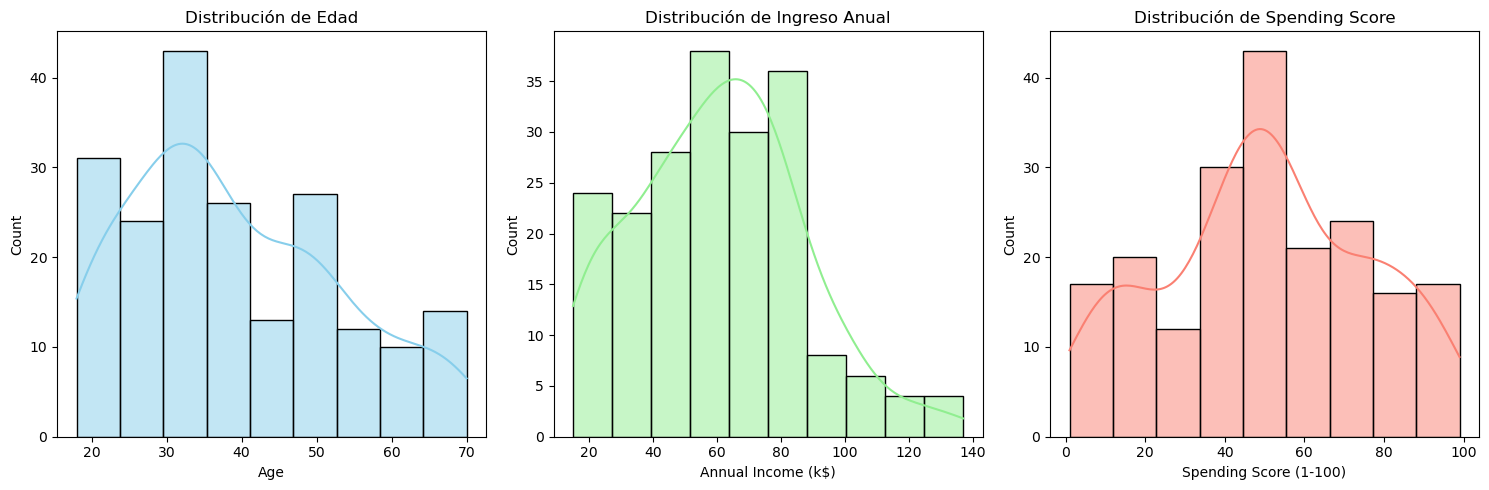

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df["Age"], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribución de Edad")

sns.histplot(df["Annual Income (k$)"], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title("Distribución de Ingreso Anual")

sns.histplot(df["Spending Score (1-100)"], kde=True, ax=axes[2], color='salmon')
axes[2].set_title("Distribución de Spending Score")

plt.tight_layout()
plt.show()


### Hallazgos

- Edad: la mayoria de los clientes estan entre 30 y 40 años, publico objetivo serian los adultos jovenes.  
- Ingreso anual: la mayoria de los clientes tienen ingresos medios ente 60.000 y 80.000, la grafica muestra una cola a la derecha lo cual significa  que no tenemos clientes con ingresos muy altos. (Podriamos parametrisar que ingresos superiores a 120 son valores a tipicos.)
- Speding Score: EN esta distribucion podemos observar dos picos uno no muy marcado pero esta presente lo cual sugiere tender a ser una distribucion bimodal, entre los grupos de 20-40 y de 60-80. aqui se pueden tener dos grupos de comportamtiento clientes de bajo gasto y clientes de alto gasto, por lo que se hace necesario ralizar el analiss de segmentacion. para observar a detalle esto.  



## Analisis de correlacion con matiz de correalciones entre variables numericas 

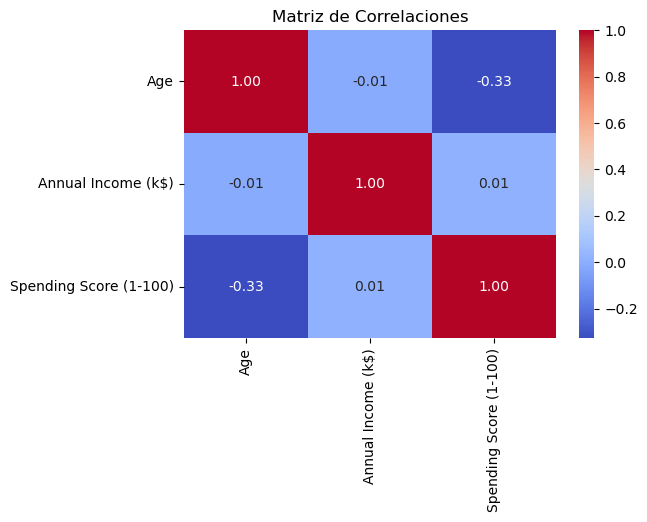

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


In [28]:

corr_matrix = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()


plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlaciones")
plt.show()

corr_matrix


Se observa una correalcion negativa entre la edad y el spending lo cual indica que los clientes jovenes tienen a gastar mas, y no se evidencia una correlacion significativa ente el ingreso y el gasto por lo que el comportamiento del consumo no depende unicamente de los ingresos. 

## Analisis segmentado por genero 

,Annual Income (k$),Spending Score (1-100)
Gender,,
Female,59.25,51.53
Male,62.23,48.51


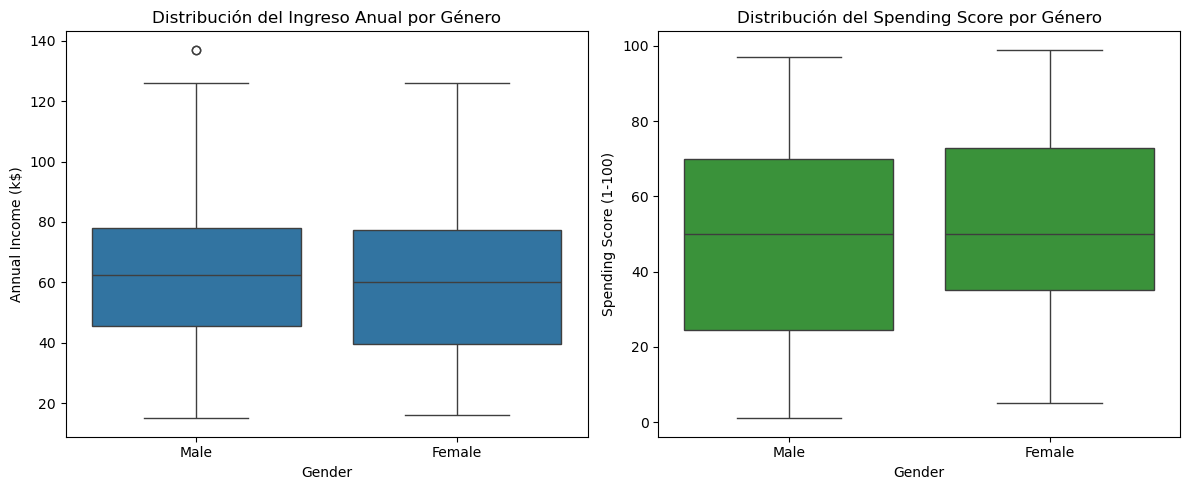

In [26]:
# Promedio de ingreso y gasto por género
gender_summary = df.groupby('Gender')[['Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
display(gender_summary)

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x='Gender', y='Annual Income (k$)', data=df, color="#1f77b4", ax=axes[0])
axes[0].set_title("Distribución del Ingreso Anual por Género")

sns.boxplot(x='Gender', y='Spending Score (1-100)', data=df, color="#2ca02c", ax=axes[1])
axes[1].set_title("Distribución del Spending Score por Género")

plt.tight_layout()
plt.show()


###  Análisis del Ingreso Anual y Spending Score por Género

Los diagramas de caja (boxplots) permiten visualizar la distribución del ingreso anual y del nivel de gasto (*Spending Score*) diferenciados por género.  

- **Ingreso Anual (k):** Se observa que tanto hombres como mujeres presentan distribuciones muy similares en sus ingresos, con medianas cercanas a los 60 k. La presencia de un valor atípico en el grupo masculino (superior a 130 k$) indica la existencia de un cliente con un ingreso considerablemente más alto que el resto.

- **Spending Score (1–100):**  
  En cuanto al puntaje de gasto, las mujeres presentan una mediana ligeramente superior (≈55) frente a los hombres (≈50), además de una mayor dispersión en sus valores. Esto sugiere que el comportamiento de gasto femenino es más variado. 


## Segementacion por EDAD 

C:\Users\USER\AppData\Local\Temp\ipykernel_13076\2515041248.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_summary = df.groupby('AgeGroup')[['Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
C:\Users\USER\AppData\Local\Temp\ipykernel_13076\2515041248.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AgeGroup', y='Annual Income (k$)', data=df, palette='Blues', ax=axes[0])
C:\Users\USER\AppData\Local\Temp\ipykernel_13076\2515041248.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn

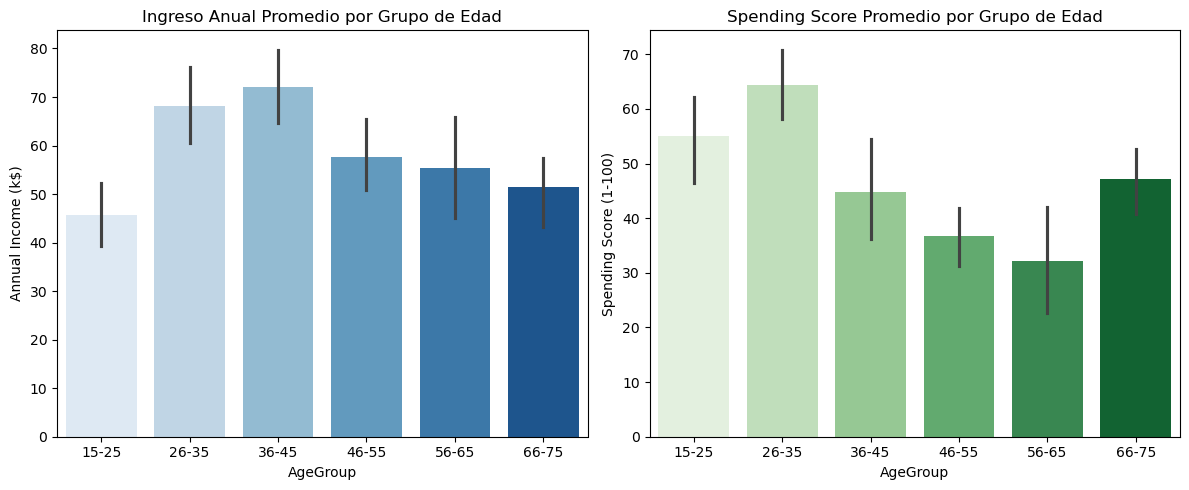

In [31]:

bins = [15, 25, 35, 45, 55, 65, 75]
labels = ['15-25', '26-35', '36-45', '46-55', '56-65', '66-75']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

age_summary = df.groupby('AgeGroup')[['Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.barplot(x='AgeGroup', y='Annual Income (k$)', data=df, palette='Blues', ax=axes[0])
axes[0].set_title("Ingreso Anual Promedio por Grupo de Edad")

sns.barplot(x='AgeGroup', y='Spending Score (1-100)', data=df, palette='Greens', ax=axes[1])
axes[1].set_title("Spending Score Promedio por Grupo de Edad")

plt.tight_layout()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_13076\3891930428.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('AgeGroup')[['Annual Income (k$)', 'Spending Score (1-100)']].mean().reset_index()


<Figure size 1000x600 with 0 Axes>

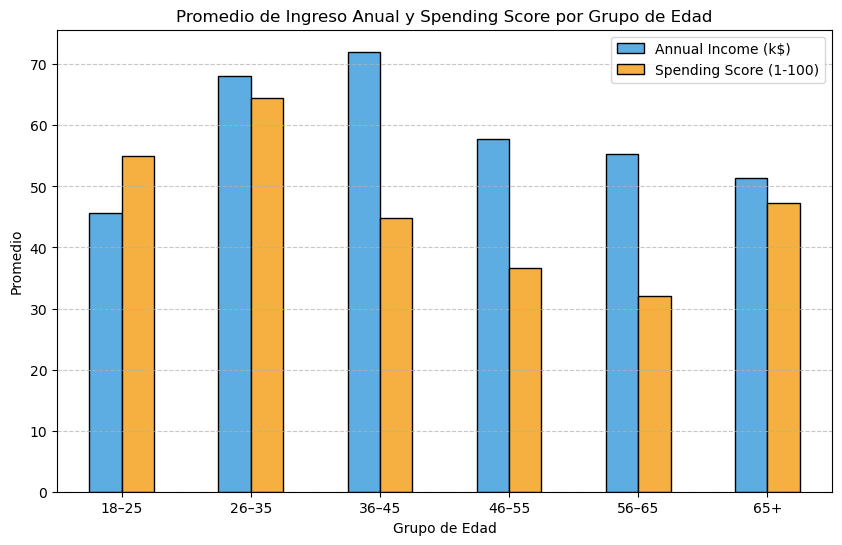

In [32]:

# Crear grupos de edad
bins = [18, 25, 35, 45, 55, 65, 70]
labels = ['18–25', '26–35', '36–45', '46–55', '56–65', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Calcular promedios por grupo
grouped = df.groupby('AgeGroup')[['Annual Income (k$)', 'Spending Score (1-100)']].mean().reset_index()

# Gráfico
plt.figure(figsize=(10,6))
grouped.plot(
    x='AgeGroup',
    kind='bar',
    figsize=(10,6),
    color=['#5DADE2', '#F5B041'],
    edgecolor='black'
)
plt.title('Promedio de Ingreso Anual y Spending Score por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Promedio')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análisis del comportamiento por grupos de edad

El gráfico muestra la distribución del ingreso anual y del *Spending Score* agrupados por rangos de edad.  
Agrupar las edades en intervalos permite observar patrones más claros y reducir la variabilidad entre edades cercanas.

**Hallazgos principales:**
- Los clientes más jóvenes (15–25 años) presentan niveles de gasto (*Spending Score*) relativamente altos, a pesar de sus ingresos más bajos.  
- Los grupos intermedios (26–45 años) alcanzan el pico de ingresos, aunque tienden a mantener un nivel de gasto más controlado.  
- A partir de los 55 años, se observa una reducción tanto en ingresos como en gasto, indicando un comportamiento más conservador.



##  Relación Income vs Spending Score

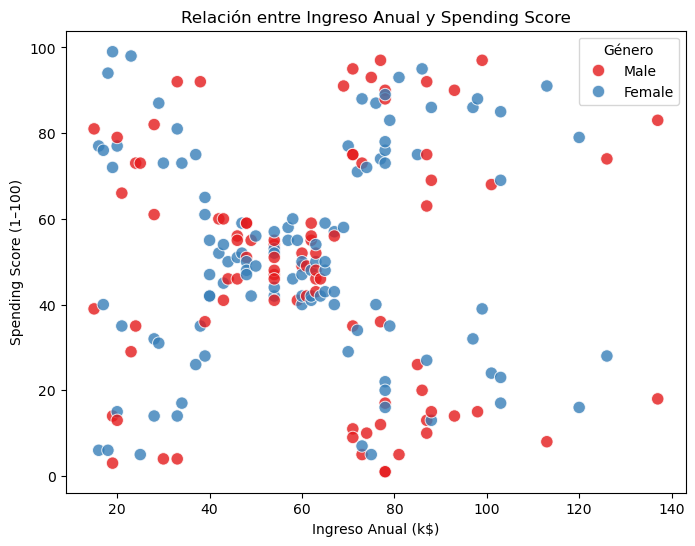

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Gender',
    palette='Set1',
    s=80,
    alpha=0.8
)
plt.title("Relación entre Ingreso Anual y Spending Score")
plt.xlabel("Ingreso Anual (k$)")
plt.ylabel("Spending Score (1–100)")
plt.legend(title="Género")
plt.show()


### Relación entre Ingreso y Spending Score

Para este apartado se elige usar un grafico de dispersion porque ambas variabels son numericas contiuan y se espera ver patrones, correlacion o agrupamientos. 

El gráfico de dispersión muestra la relación entre el ingreso anual y el nivel de gasto de los clientes.

Se observa que no existe una correlación lineal evidente entre ambas variables:  
clientes con ingresos altos no necesariamente presentan un *Spending Score* elevado.  

En cambio, los puntos tienden a agruparse en distintas zonas, lo que sugiere la existencia de **patrones de comportamiento diferenciados**.  
Por ejemplo:
- Un grupo con **bajo ingreso y bajo gasto**, típico de consumidores conservadores.  
- Otro con **alto ingreso pero bajo gasto**, posible perfil de ahorradores o de bajo interés en ofertas.  
- Y un grupo con **ingresos medios y alto gasto**, representando consumidores más impulsivos.


##  Insights principales del análisis exploratorio

Tras evaluar la calidad de los datos y analizar las variables principales, se identificaron los siguientes hallazgos de relevancia para el negocio:

1. **Comportamiento de gasto no lineal respecto al ingreso:**  
   El *Spending Score* no aumenta proporcionalmente con el *Annual Income*.  
   Existen clientes con altos ingresos pero bajo nivel de gasto, y otros con ingresos medios o bajos que gastan considerablemente más.  
   Esto sugiere que el nivel de ingreso no es el único determinante del comportamiento de compra. esto sugiere que existen otros patrones para determinar el perfil de compras. 

2. **Diferencias de consumo por edad:**  
   Los clientes jóvenes (18–25 años) tienden a presentar los niveles de gasto más altos pese a tener ingresos más bajos, mientras que los grupos mayores muestran patrones más conservadores.  
   Esto indica que la edad influye más en el gasto que la capacidad adquisitiva, lo cual es clave para diseñar estrategias de segmentación por etapa de vida.

3. **Distribución equilibrada por género, pero diferencias en gasto:**  
   Aunque los ingresos promedio entre hombres y mujeres son similares, las mujeres muestran un rango de *Spending Score* más amplio, con presencia de valores más altos.  
   Esto refleja una mayor heterogeneidad en el comportamiento de compra femenino, lo que podría implicar la existencia de subgrupos con motivaciones distintas dentro de este segmento.



## Seccion 2: K-Means Clustering 

### Normalizacion de datos 

El análisis se realizó sobre las variables Annual Income (k$) y Spending Score (1–100), ya que representan los factores más relevantes para la segmentación de clientes desde el punto de vista comercial.


// Seria necesario decir que se intento metiendo la edad pero no dio un cluster bien identificado ?? 

In [60]:
from sklearn.preprocessing import StandardScaler


features = ["Annual Income (k$)", "Spending Score (1-100)"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled[:5])



[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]


## Determinacion del k optimo 

Se utiliza el metodo de codo para determinar el K optimo, en este caso probamos con valores de K de 1 hasta 10 este rango se tuyiliza por que es un punto de partida standar debido a que el dataset no es muy grande y con la realcion vista en Relación Income vs Spending Score se puee inferir mediante la grafica que podemos tener unos 5 grupos mas o menos, pero vamos a comprobarlo.  

C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.p

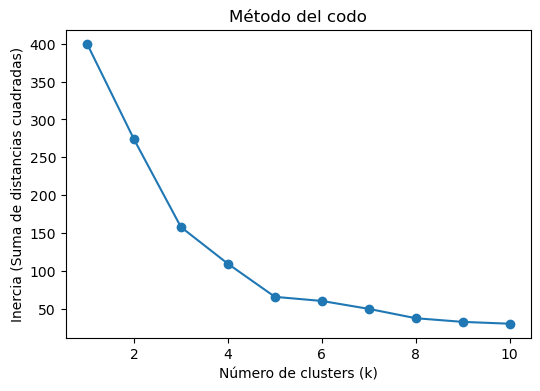

In [61]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de distancias cuadradas)')
plt.show()


Con la grafica anterior estamos buscando el punto visual donde se forma el codo, se puede observar que entre k=2 y k=4 la inercia disminuye rapidamente lo cual quiere decir que el agrupamiento mejora bastante de ahi en adelante la mejora no es muy significativa. 

Ya que mediante la grafica se puede asegurar que el K optimo esta entre 4 y 6. pero se debe realizar un analisis para calcular el Silhouette Score para determinar cual seria el K adecuado. 

###  Silhouette Score


C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.p

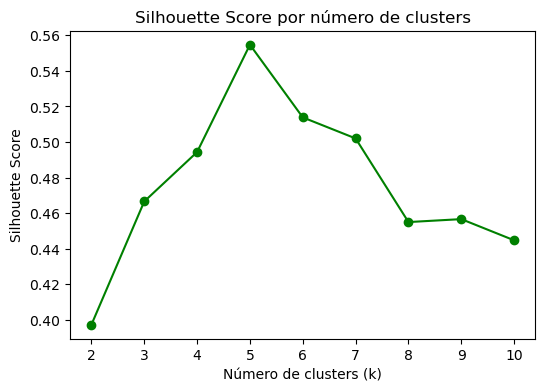

In [62]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score por número de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

Ya que con este metodo se busca el numero de K que mas se acerque a 1 en el Silhouette Score, el K optimo para este ejericico sera el 5, ya que da el valor mas cercano al 1. Y este valor de K era aproximado al esperado por la formacion de los grupos en Relación Income vs Spending Score


C:\Users\USER\.conda\envs\ml_segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


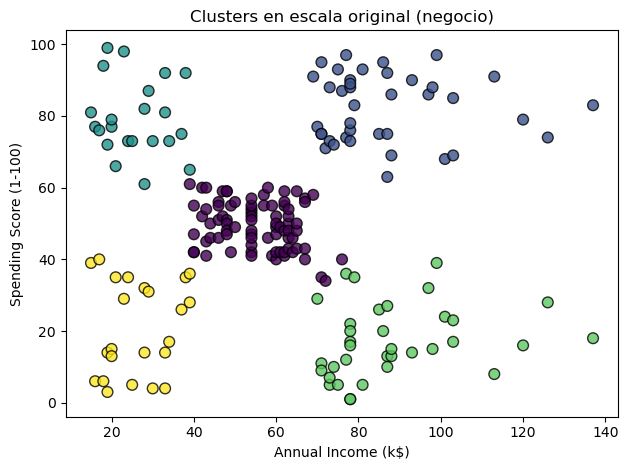

In [65]:
k_optimo = 5
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)


plt.scatter(
    df["Annual Income (k$)"], df["Spending Score (1-100)"],
    c=df["Cluster"], cmap='viridis', s=60, alpha=0.8, edgecolor='k'
)
plt.title("Clusters en escala original (negocio)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")

plt.tight_layout()
plt.show()



Al observar la dispersión de puntos (Income vs Spending Score):

**Cluster 0 – Bajo ingreso, bajo gasto:**
Clientes con poder adquisitivo limitado y bajo nivel de gasto. 

**Cluster 1 – Alto ingreso, alto gasto:**
Segmento premium o “High Value Customers”. 

**Cluster 2 – Ingreso medio, gasto medio:**
Grupo estable que puede responder a incentivos o descuentos.

**Cluster 3 – Bajo ingreso, gasto alto:**
Clientes que gastan más de lo esperado respecto a su ingreso. 

**Cluster 4 – Alto ingreso, bajo gasto:**
Clientes con capacidad económica pero bajo nivel de consumo. 

In [46]:
# Perfilamiento de cada segmento
cluster_profile = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
cluster_profile['Count'] = df['Cluster'].value_counts().sort_index()
cluster_profile


,Age,Annual Income (k$),Spending Score (1-100),Count
Cluster,,,,
0,56.333333,54.266667,49.066667,45
1,32.692308,86.538462,82.128205,39
2,25.560000,26.480000,76.240000,25
3,26.125000,59.425000,44.450000,40
4,44.000000,90.133333,17.933333,30
5,45.523810,26.285714,19.380952,21


**El modelo logra una segmentación significativa que permite identificar perfiles con distintos comportamientos de consumo.
A partir de esta clasificación, el negocio puede diseñar estrategias diferenciadas de marketing, promociones o fidelización, asignando recursos de forma más eficiente**.